In [1]:
"""
This code necessitates the use of an older version of the contrib version of 
the openCV package (because SIFT is a patented algorithm...). 

TRY DOING:
    
pip uninstall opencv-python 

[If previously installed]. Then both

pip install opencv-python==3.4.2.16
pip install opencv-contrib-python==3.4.2.16
"""
import pickle
import matplotlib.pyplot as plt
from skimage.transform import resize
import cv2
import numpy as np
import os
from os import listdir
import os.path as op
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors


In [ ]:
'''
PART 1

SCRIPT TO REMOVE THE 20% IMAGES WITH THE SMALLEST NB OF NON-ZERO PIXELS

'''

with open('./data/GO_terms.pkl', 'rb') as handle:
    GO_terms = pickle.load(handle)

path = op.abspath('./data/allendata')
genes = [f for f in listdir(path)]

info={} #make a dictionary which will contain the image id, gene id, non-zero count and the image itself, and the GO terms as well
geneNb = 0
for gene in genes:
    try:
        GO_terms[gene]
    except:
        continue #pass this gene if it doesn't have GO terms
    gene_path = path+'/'+gene
    genes_images = [f for f in listdir(gene_path)]
    for gene_image in genes_images:
        file = gene_path+'/'+gene_image
        img = cv2.imread(file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        nzCount = cv2.countNonZero(gray_img);
        info[gene_image]=[gene, nzCount, gray_img, GO_terms[gene]]
    if geneNb%1000==0:
        print(geneNb)
    geneNb += 1


filename='data/data_info.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(info, handle)


In [2]:
filename='data/data_info.pkl'
with open(filename, 'rb') as handle:
    info=pickle.load(handle)
    
keys=info.keys()
GO_terms=[]
genes=[]
gene_image_file=[]
gene_image_nz=[]
images_list=[]
for key in keys:
    genes.append(info[key][0])
    gene_image_nz.append(info[key][1])
    gene_image_file.append(key)
    images_list.append(info[key][2])
    GO_terms.append(info[key][3])
    
#delete images/genes which are in the lowest 20% non-zero count
geneNb=len(info)
genes_array = np.array(genes)
image_files = np.array(gene_image_file)
image_nz = np.array(gene_image_nz)
k = int(geneNb/5)
idx = np.argpartition(image_nz, k)
id_smallest = idx[:k]

image_files_rem = image_files[idx[k:]]
image_nz_rem = image_nz[idx[k:]]
genes_rem = genes_array[idx[k:]]
GO_terms_rem=np.asarray(GO_terms)[idx[k:]]
images_list_rem=np.asarray(images_list)[idx[k:]]


In [3]:
'''
PICK THE GO TERMS THAT SHOW UP IN BETWEEN 50 and 500 Slices
'''

GO_annotations_nb = {}
for GO_list in GO_terms_rem:
    for GO_term in GO_list:
        if GO_term in GO_annotations_nb:
            GO_annotations_nb[GO_term] += 1
        else:
            GO_annotations_nb[GO_term] = 1

list50to500GO = []
list50to500values = []
for GO in GO_annotations_nb.keys():
    if GO_annotations_nb[GO] > 51 and GO_annotations_nb[GO] < 501:
        list50to500GO.append(GO)
        list50to500values.append(GO_annotations_nb[GO])


In [4]:
'''
SIFT FUNCTION
'''
def extract_BoW(images, extract_nb):
    
    kmeans = KMeans(n_clusters=500, n_init=3)
    
    #Array that stores the concatenated descriptors (at 4 different resolutions)
    sift_all_1 = np.array([], dtype=np.int64).reshape(0,128)
    sift_all_2 = np.array([], dtype=np.int64).reshape(0,128)
    sift_all_4 = np.array([], dtype=np.int64).reshape(0,128)
    sift_all_8 = np.array([], dtype=np.int64).reshape(0,128)
    
    #For each images, get the descriptors (at 4 different resolutions)
    imageNb = 0        
    for gray_img in images:
        
        if imageNb%1000==0:
            print(imageNb)
        if imageNb==extract_nb:
            break
        
        for i in range(4):
        
            sift = cv2.xfeatures2d.SIFT_create()
            kp = sift.detect(gray_img,None)
            kp,des = sift.compute(gray_img, kp)   
            
            if i==0:
                if des is not None:
                    sift_all_1 = np.vstack([sift_all_1, des])
            
            if i==1:
                if des is not None:
                    sift_all_2 = np.vstack([sift_all_2, des])
            
            if i==2:
                if des is not None:
                    sift_all_4 = np.vstack([sift_all_4, des])
            
            if i==3:
                if des is not None:
                    sift_all_8 = np.vstack([sift_all_8, des])
            
            scale_percent = 50
            width = int(gray_img.shape[1] * scale_percent / 100)
            height = int(gray_img.shape[0] * scale_percent / 100)
            dim = (width, height)
            gray_img = cv2.resize(gray_img, dim, interpolation = cv2.INTER_AREA)
        
        imageNb +=1

    print('Clustering the SIFT at 4 scales.')
    dict_1 = kmeans.fit(sift_all_1).cluster_centers_
    dict_2 = kmeans.fit(sift_all_2).cluster_centers_
    dict_4 = kmeans.fit(sift_all_4).cluster_centers_
    dict_8 = kmeans.fit(sift_all_8).cluster_centers_
    
    return dict_1, dict_2, dict_4, dict_8


In [10]:
'''
MAIN
'''
extract_nb = len(images_list_rem) #nb of images that we want to compute the features from
#dict_1, dict_2, dict_4, dict_8 = extract_BoW(images_list_rem, extract_nb)


In [11]:
#the final feature array extracted from SIFT

dict_1=np.load('data/dict_1.npy')
dict_2=np.load('data/dict_2.npy')
dict_4=np.load('data/dict_4.npy')
dict_8=np.load('data/dict_8.npy')

genes_features = np.zeros((extract_nb, 2004))

knearest1 = NearestNeighbors(n_neighbors=1)
knearest2 = NearestNeighbors(n_neighbors=1)
knearest4 = NearestNeighbors(n_neighbors=1)
knearest8 = NearestNeighbors(n_neighbors=1)

knearest1.fit(dict_1)
knearest2.fit(dict_2)
knearest4.fit(dict_4)
knearest8.fit(dict_8)

imageNb = 0

for gray_img in images_list:
    
    if imageNb%1000==0:
        print(imageNb)
    if imageNb==extract_nb:
        break
    
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(gray_img,None)
    kp,des = sift.compute(gray_img, kp)   

    for i in range(4):
        if i==0:
            if des is not None:
                for i in range(len(des)):
                    nearest = knearest1.kneighbors(des[i,:].reshape(1,128), 1, return_distance=False)
                    genes_features[imageNb,nearest] +=1
            else:
                genes_features[imageNb,2000] += 1
        if i==1:
            if des is not None:
                for i in range(len(des)):
                    nearest = knearest2.kneighbors(des[i,:].reshape(1,128), 1, return_distance=False)
                    genes_features[imageNb,nearest+500] += 1
            else:
                genes_features[imageNb,2001] += 1
        if i==2:
            if des is not None:
                for i in range(len(des)):
                    nearest = knearest4.kneighbors(des[i,:].reshape(1,128), 1, return_distance=False)
                    genes_features[imageNb,nearest+1000] += 1
            else:
                genes_features[imageNb,2002] += 1
        if i==3:
            if des is not None:
                for i in range(len(des)):
                    nearest = knearest8.kneighbors(des[i,:].reshape(1,128), 1, return_distance=False)
                    genes_features[imageNb,nearest+1500] += 1
            else:
                genes_features[imageNb,2003] += 1
            
        scale_percent = 50
        width = int(gray_img.shape[1] * scale_percent / 100)
        height = int(gray_img.shape[0] * scale_percent / 100)
        dim = (width, height)
        gray_img = cv2.resize(gray_img, dim, interpolation = cv2.INTER_AREA) 
        
    imageNb += 1


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [12]:
SIFT_dict={'genes_features':genes_features, 'GO_terms':GO_terms_rem}

filename='data/SIFT_data.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(SIFT_dict, handle)


In [ ]:
'''
Resize images + PCA
'''

In [2]:
image_dir='data/allendata/'
dir_list=os.listdir(image_dir)

filename='data/GO_terms.pkl'
with open(filename, 'rb') as handle:
    GO_data=pickle.load(handle)

In [3]:
i=0
data_list=[]
for gene_id in dir_list:
    try:
        GO_terms=GO_data[str(gene_id)]
        gene_dir=image_dir+gene_id+'/'
        jpg_files=os.listdir(gene_dir)
        for jpg_file in jpg_files:
            img = cv2.imread(gene_dir+jpg_file)
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=resize(gray_img, (140,300), anti_aliasing=True) #resize all images to 140x300
            img=img*255 #multiply by 255 to scale images back to the same integer value distribution
            img=np.asarray(img, dtype='uint8')
            data_list.append(img)
    except:
        continue
    i+=1
    if i%1000==0:
        break
        print(i)



/home/desgab/.local/easybuild/software/2017/Core/miniconda3/4.3.27/envs/comp551/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [4]:
data_array=np.asarray(data_list)
shape=data_array.shape
X=data_array.reshape(shape[0], shape[1]*shape[2])

In [5]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [13]:
components=pca.components_[:10,:]

In [18]:
img_comp=components.reshape(10,shape[1],shape[2])

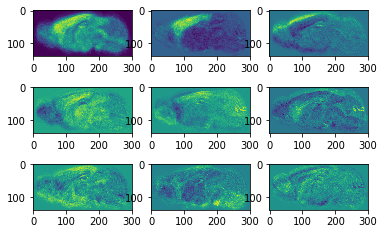

In [23]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]]=plt.subplots(3,3)
axes=[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]]
i=0
for ax_3 in axes:
    for ax in ax_3:
        ax.imshow(img_comp[i,:,:])
        i+=1
fig.savefig('9_components.pdf')

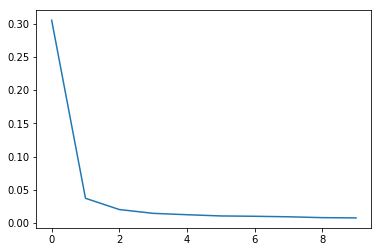

In [12]:
plt.plot(pca.explained_variance_ratio_[:10])